# Stochastic variational deep kernel learning

In [1]:
%%capture
!pip install gpytorch

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from sklearn.preprocessing import StandardScaler
import gpytorch
import tqdm
from torch.utils.data import TensorDataset, DataLoader
import os

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/virgo/")

%matplotlib inline
%load_ext autoreload
%autoreload 2

# https://arxiv.org/pdf/1511.02222.pdf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
all_clusters = np.loadtxt('./demo_notebooks/vc_cleaned_cluster.txt')
all_labs = np.loadtxt('./demo_notebooks/vc_cleaned_cluster_labels.txt')
all_data = np.array([*all_clusters.T, all_labs]).T
np.random.shuffle(all_data)
all_clusters = all_data[:, :-1]
all_labs = all_data[:, -1].T
all_labs_cp = all_labs

use_dim = [0, 1, 2, 3, 4, 5]
n_dim = len(use_dim)
n_classes = np.unique(all_labs_cp[all_labs_cp!=-1.]).shape[0]
all_clusters = all_clusters[:, use_dim]

print(n_dim, n_classes)
print(all_clusters.min(), all_clusters.max(), all_clusters.mean())
scaler = StandardScaler()
scaler.fit(all_clusters)
all_clusters = scaler.transform(all_clusters)
print(all_clusters.min(), all_clusters.max(), all_clusters.mean())

n_max_data = 30000
train_x_np = all_clusters[all_labs_cp!=-1.][:n_max_data]
train_y_np = all_labs_cp[all_labs_cp!=-1.][:n_max_data]

n_cut = 3000
train_x = torch.tensor(train_x_np[:-n_cut], dtype=torch.float32)
train_y = torch.tensor(train_y_np[:-n_cut], dtype=torch.float32)
test_x = torch.tensor(train_x_np[-n_cut:], dtype=torch.float32)
test_y = torch.tensor(train_y_np[-n_cut:], dtype=torch.float32)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

6 7
-6317.1884765625 7894.587890625 550.9000687336552
-4.164443392067588 3.4729634870262305 3.7786277040101406e-17
torch.Size([27000, 6]) torch.Size([27000])
torch.Size([3000, 6]) torch.Size([3000])


In [4]:
class MultitaskBernoulliLikelihood(gpytorch.likelihoods.Likelihood):
    def forward(self, function_samples, **kwargs):

#         prob = torch.exp(function_samples)
        prob = function_samples
#         print(prob.shape, prob.dtype)
        output_probs = torch.distributions.Normal(0, 1).cdf(prob)
        out = torch.distributions.Independent(torch.distributions.Bernoulli(probs=output_probs), 1)
#         out = torch.distributions.Independent(torch.distributions.Bernoulli(logits=output_probs), 1)
#         print(out)
    
        return out

class DenseNetFeatureExtractor(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = 50
        self.hidden = 100

        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_dim, self.hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden, self.hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden, self.num_features),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        out = self.net(x)
        return out

num_classes = n_classes
feature_extractor = DenseNetFeatureExtractor(num_classes=num_classes)
num_features = feature_extractor.num_features
print(num_features, num_classes)

50 7


In [5]:
class GaussianProcessLayer(gpytorch.models.ApproximateGP):
    def __init__(self, num_dim, grid_bounds=(-10., 10.), grid_size=64):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=grid_size, batch_shape=torch.Size([num_dim])
        )

        # Our base variational strategy is a GridInterpolationVariationalStrategy,
        # which places variational inducing points on a Grid
        # We wrap it with a IndependentMultitaskVariationalStrategy so that our output is a vector-valued GP
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.GridInterpolationVariationalStrategy(
                self, grid_size=grid_size, grid_bounds=[grid_bounds],
                variational_distribution=variational_distribution,
            ), num_tasks=num_dim,
        )
        super().__init__(variational_strategy)

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=gpytorch.priors.SmoothedBoxPrior(
                    math.exp(-1), math.exp(1), sigma=0.1, transform=torch.exp
                )
            )
        )
        self.mean_module = gpytorch.means.ConstantMean()
        self.grid_bounds = grid_bounds

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [6]:
class DKLModel(gpytorch.Module):
    def __init__(self, feature_extractor, num_dim, grid_bounds=(-10., 10.)):
        super(DKLModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.gp_layer = GaussianProcessLayer(num_dim=num_dim, grid_bounds=grid_bounds)
        self.grid_bounds = grid_bounds
        self.num_dim = num_dim

        # This module will scale the NN features so that they're nice values
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(self.grid_bounds[0], self.grid_bounds[1])

    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.scale_to_bounds(features)
        # This next line makes it so that we learn a GP for each feature
        features = features.transpose(-1, -2).unsqueeze(-1)
        res = self.gp_layer(features)
        return res

model = DKLModel(feature_extractor, num_dim=num_features)
likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_features=model.num_dim, num_classes=num_classes)

test_res = model(torch.rand(1024, n_dim))
print(test_res)

# If you run this example without CUDA, I hope you like waiting!
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

MultitaskMultivariateNormal(loc: torch.Size([51200]))


In [7]:
from torch.optim.lr_scheduler import MultiStepLR
n_epochs = 5
lr = 0.1
optimizer = torch.optim.Adam(
    [
    {'params': model.feature_extractor.parameters(), 'weight_decay': 1e-4},
    {'params': model.gp_layer.hyperparameters(), 'lr': lr * 0.01},
    {'params': model.gp_layer.variational_parameters()},
    {'params': likelihood.parameters()},
     ],
     lr=lr,
)
scheduler = MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs], gamma=0.1)
mll = gpytorch.mlls.VariationalELBO(likelihood, model.gp_layer, num_data=len(train_loader.dataset))


def train(epoch):
    model.train()
    likelihood.train()

    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc=f"(Epoch {epoch}) Minibatch")
    with gpytorch.settings.num_likelihood_samples(8):
        for data, target in minibatch_iter:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = -mll(output, target)
            loss.backward()
            optimizer.step()
            minibatch_iter.set_postfix(loss=loss.item())

def test():
    model.eval()
    likelihood.eval()

    correct = 0
    with torch.no_grad(), gpytorch.settings.num_likelihood_samples(16):
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            output = likelihood(model(data))  # This gives us 16 samples from the predictive distribution
            pred = output.probs.mean(0).argmax(-1)  # Taking the mean over all of the sample we've drawn
            correct += pred.eq(target.view_as(pred)).cpu().sum()
    print('Test set: Accuracy: {}/{} ({}%)'.format(
        correct, len(test_loader.dataset), 100. * correct / float(len(test_loader.dataset))
    ))

In [8]:
for epoch in range(1, n_epochs + 1):
    with gpytorch.settings.use_toeplitz(False):
        train(epoch)
        test()
    scheduler.step()
    state_dict = model.state_dict()
    likelihood_state_dict = likelihood.state_dict()
    torch.save({'model': state_dict, 'likelihood': likelihood_state_dict}, 'dkl_cifar_checkpoint.dat')

(Epoch 1) Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Test set: Accuracy: 2542/3000 (84.73332977294922%)


(Epoch 2) Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Test set: Accuracy: 2780/3000 (92.66666412353516%)


(Epoch 3) Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Test set: Accuracy: 2815/3000 (93.83333587646484%)


(Epoch 4) Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Test set: Accuracy: 2831/3000 (94.36666870117188%)


(Epoch 5) Minibatch:   0%|          | 0/27 [00:00<?, ?it/s]

Test set: Accuracy: 2842/3000 (94.73332977294922%)


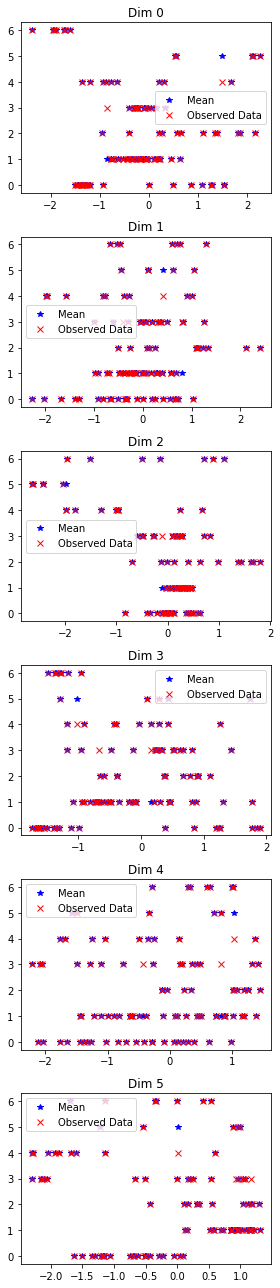

In [9]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(n_dim, 1, figsize=(4, 3 * n_dim))
    

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        if torch.cuda.is_available():
                x_batch, y_batch = x_batch.cuda(), y_batch.cuda()
        
        x_batch = x_batch[::10]
        y_batch = y_batch[::10]
        # mean = torch.round(model(x_batch).mean).cpu()
        # mean = (model(x_batch).mean).cpu()
        output = likelihood(model(x_batch))  # This gives us 16 samples from the predictive distribution
        mean = output.probs.mean(0).argmax(-1).cpu()
        
        for xdim in range(n_dim):
            ax = axs[xdim]
            
            ax.plot(x_batch[:, xdim].cpu().detach().numpy(), mean.detach().numpy(), '*b')
            ax.plot(x_batch[:, xdim].cpu().detach().numpy(), y_batch.cpu().detach().numpy(), 'xr', alpha=0.99)
            ax.legend([ 'Mean', 'Observed Data'])
            ax.set_title(f'Dim {xdim}')
        break

fig.tight_layout()
plt.show()


(14479, 6) 31458.0


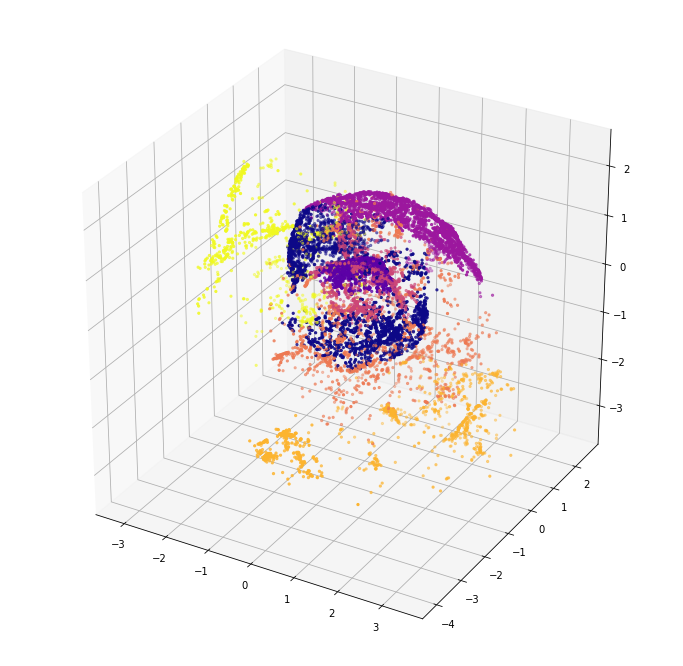

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

plot_data = all_clusters[::40]
plot_y = all_labs[::40]
print(plot_data.shape, plot_y.sum())
ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")

plt.show()

tensor(0) tensor(6)
(14479, 6) tensor(30846)


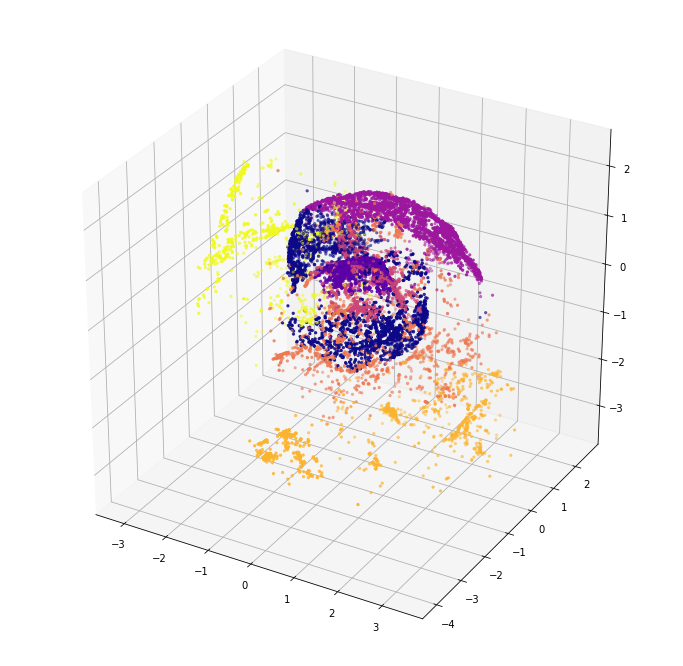

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

eval_data = torch.tensor(all_clusters[::40], dtype=torch.float32)
if torch.cuda.is_available(): 
    eval_data = eval_data.cuda()

output = likelihood(model(eval_data))
mean = output.probs.mean(0).argmax(-1).cpu()
plot_y = mean.cpu().detach().numpy()
plot_data = eval_data.cpu().detach().numpy()

print(mean.min(), mean.max())
print(plot_data.shape, mean.sum())
ax.scatter(plot_data.T[0], plot_data.T[1], plot_data.T[2], c=plot_y, marker=".", cmap="plasma")
plt.show()

In [12]:
# SVGP https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.html
# SVGP CLass https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html
# DKL Multiclass https://docs.gpytorch.ai/en/stable/examples/06_PyTorch_NN_Integration_DKL/Deep_Kernel_Learning_DenseNet_CIFAR_Tutorial.html
# Exact Dirichlet https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html?highlight=dirichlet

# https://github.com/cornellius-gp/gpytorch/issues/1396